## Analyzing Entropy for a Random Circuit
Considering circuits different number of Qubits and varying Depths

**1) Configure Qiskit Runtime Service, and Input Parameters**
<br/>
Input Parameters:
- Range for number of qubits
- Circuit depth range
- Number of circuit runs

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
from config import api_key
import numpy as np

# Save an IBM Quantum account as your default account, and Load saved credentials
QiskitRuntimeService.save_account(
    channel="ibm_quantum", token=api_key, set_as_default=True, overwrite=True
)
service = QiskitRuntimeService()

# Define Input Parameters
num_q = np.arange(2, 6, 1)
depths = np.arange(3, 61, 1)
runs = 20

**2) Generate Random Circuits and Compute Entropy**

In [4]:
from qiskit.providers.basic_provider import BasicSimulator
import pandas as pd
from random_circuit import eagle_gate_set, basis_gate_set
from random_circuit import get_random_circuit
from entropy import get_average_entropy
from utils import get_measurement

# Define backend to run jobs
backend = BasicSimulator()
# backend = service.backend("ibmq_qasm_simulator")

# Choose a set of gates to build circuit
gate_set = basis_gate_set

# Calculate entropy - Looping over depth and number of qubits
data_list = []
for n in num_q:
    for d in depths:
        circuit = get_random_circuit(n, d, gate_set)
        measurement = get_measurement(circuit, runs, backend)
        entropy = get_average_entropy(measurement)
        data_list.append(
            {
                "Num": n,
                "depth": d,
                "entropy": entropy,
                "circuit": circuit,
                "measurement": measurement,
            }
        )
data = pd.DataFrame(data_list)

# Print the DataFrame
print(data)

     Num  depth   entropy                                            circuit  \
0      2      3  0.749321  ((Instruction(name='y', num_qubits=1, num_clbi...   
1      2      4  0.799194  ((Instruction(name='x', num_qubits=1, num_clbi...   
2      2      5  0.674161  ((Instruction(name='id', num_qubits=1, num_clb...   
3      2      6  0.749308  ((Instruction(name='cx', num_qubits=2, num_clb...   
4      2      7  0.798900  ((Instruction(name='y', num_qubits=1, num_clbi...   
..   ...    ...       ...                                                ...   
227    5     56  0.678070  ((Instruction(name='swap', num_qubits=2, num_c...   
228    5     57  0.708139  ((Instruction(name='ccx', num_qubits=3, num_cl...   
229    5     58  0.598695  ((Instruction(name='id', num_qubits=1, num_clb...   
230    5     59  0.568443  ((Instruction(name='y', num_qubits=1, num_clbi...   
231    5     60  0.618743  ((Instruction(name='ccx', num_qubits=3, num_cl...   

                                       

**3) Plot Entropy vs Depth for different Number of Qubits**

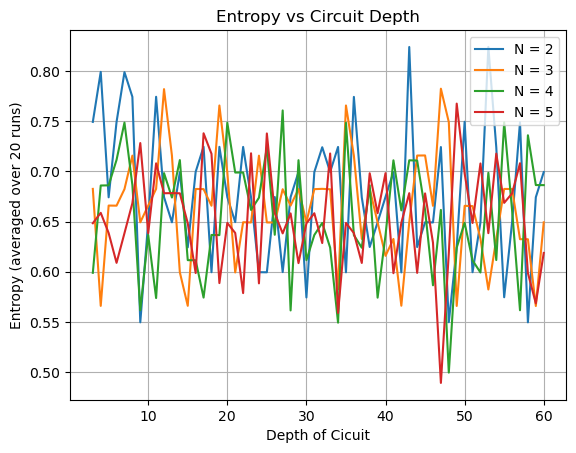

In [6]:
import matplotlib.pyplot as plt

# Plotting
plt.title("Entropy vs Circuit Depth")
plt.xlabel("Depth of Cicuit")
plt.ylabel("Entropy (averaged over " + str(runs) + " runs)")

for N in num_q:
    filtered_df = data[data["Num"] == N]
    lbl = "N = " + str(N)
    plt.plot(filtered_df["depth"], filtered_df["entropy"], label=lbl)

plt.grid(True)
plt.legend()
plt.show()

**4) Find circuit with Lowest and Highest Entropy for given Depth**

In [9]:
from entropy import get_extreme_entropy_data

# Printing circuit with highest and lowest entropy
depth = 24
highest, lowest = get_extreme_entropy_data(data, depth)
print("Circuit with the highest entropy = " + str(highest["entropy"]) + " for depth" + str(depth) + ":")
print(highest["circuit"])
print("Circuit with the lowest entropy = " + str(lowest["entropy"]) + " for depth "+ str(depth) + ":")
print(lowest["circuit"])

Circuit with the highest entropy = 0.7156632557169832 for depth24:
                                    ┌───┐┌───┐          ┌───┐┌───┐┌───┐     »
q_0: ──────X───■─────────────X───■──┤ I ├┤ X ├──■───────┤ X ├┤ Z ├┤ Z ├──X──»
     ┌───┐ │   │  ┌───┐┌───┐ │   │  ├───┤├───┤  │  ┌───┐└─┬─┘├───┤├───┤  │  »
q_1: ┤ Z ├─┼───┼──┤ I ├┤ Z ├─┼───■──┤ I ├┤ X ├──┼──┤ Z ├──■──┤ X ├┤ Z ├──X──»
     └───┘ │ ┌─┴─┐└───┘└───┘ │ ┌─┴─┐├───┤├───┤┌─┴─┐└───┘  │  └─┬─┘├───┤┌───┐»
q_2: ──────X─┤ X ├───────────X─┤ X ├┤ Y ├┤ I ├┤ X ├───────■────■──┤ Y ├┤ Z ├»
             └───┘             └───┘└───┘└───┘└───┘               └───┘└───┘»
«          ┌───┐               ┌───┐          ┌───┐        ┌───┐┌───┐┌───┐
«q_0: ──■──┤ X ├──■────■────X──┤ X ├──■────■──┤ Y ├──────X─┤ Y ├┤ Z ├┤ Y ├
«       │  ├───┤┌─┴─┐┌─┴─┐  │  └─┬─┘  │    │  ├───┤┌───┐ │ ├───┤├───┤├───┤
«q_1: ──■──┤ I ├┤ X ├┤ X ├──X────■────■────■──┤ I ├┤ Z ├─┼─┤ Z ├┤ X ├┤ Z ├
«     ┌─┴─┐├───┤├───┤├───┤┌───┐  │  ┌─┴─┐┌─┴─┐├───┤└───┘ │ ├───┤└─┬─┘├───┤
«q_2: ┤ X ├┤

**5) Lowest and Highest Entropy circuit analysis - Measurement Histogram and Bloch Sphere**

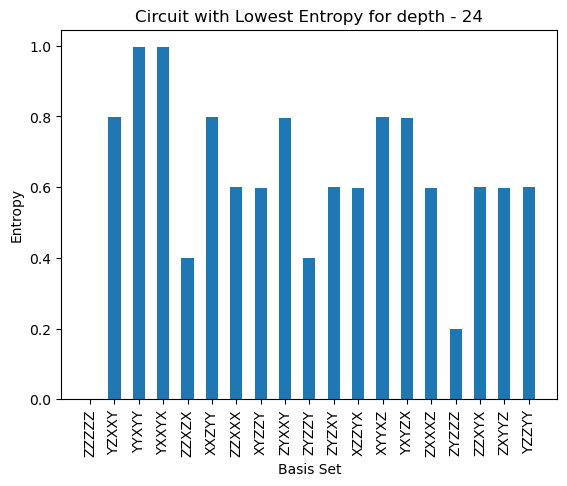

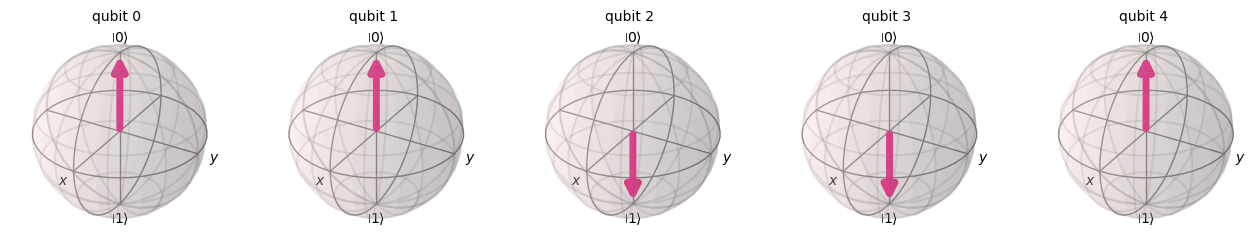

In [12]:
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_bloch_multivector
from entropy import get_entropy_list

# Lowest Entropy Circuit - Measurement Histogram and Bloch Sphere
low_entropy = get_entropy_list(lowest["measurement"])
basis = list(low_entropy.keys())
entropy_low = list(low_entropy.values())
plt.title("Circuit with Lowest Entropy for depth - " + str(depth))
plt.xlabel("Basis Set")
plt.ylabel("Entropy")
plt.bar(basis, entropy_low, width=0.5)
plt.xticks(rotation='vertical')
plt.show()

density_matrix = DensityMatrix.from_instruction(lowest["circuit"])
plot_bloch_multivector(density_matrix)

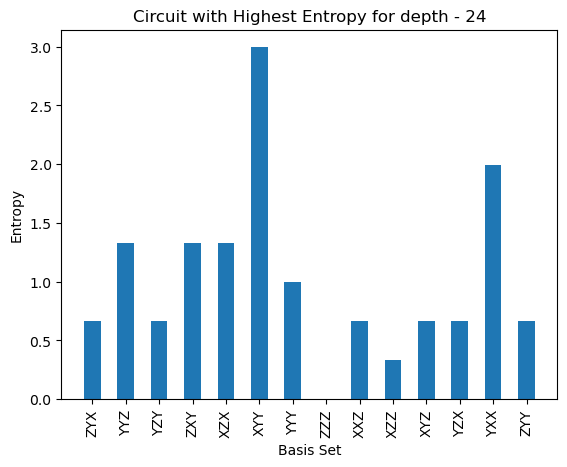

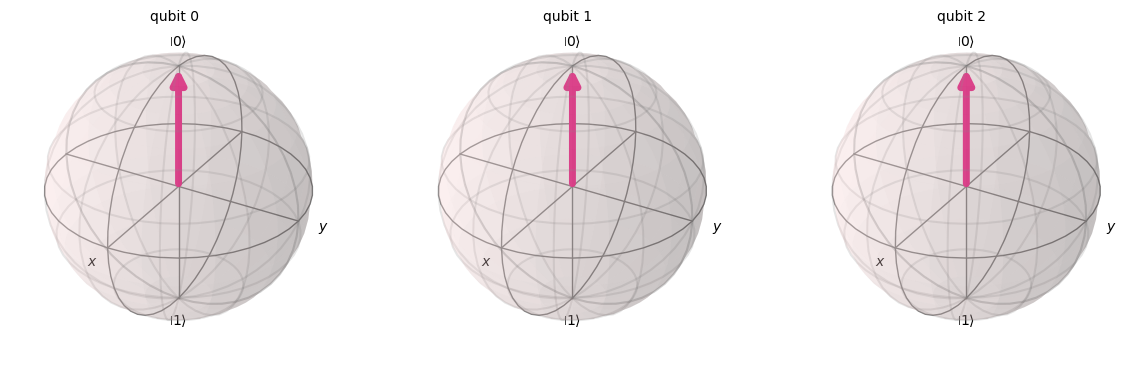

In [13]:
# Highest Entropy Circuit - Measurement Histogram and Bloch Sphere
high_entropy = get_entropy_list(highest["measurement"])
basis = list(high_entropy.keys())
entropy_high = list(high_entropy.values())
plt.title("Circuit with Highest Entropy for depth - " + str(depth))
plt.xlabel("Basis Set")
plt.ylabel("Entropy")
plt.bar(basis, entropy_high, width=0.5)
plt.xticks(rotation='vertical')
plt.show()

density_matrix = DensityMatrix.from_instruction(highest["circuit"])
plot_bloch_multivector(density_matrix)